In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

%matplotlib inline

In this notebook we do some analyses and plots of the residual circulation. We begin by loading the dataset. I found that $\bar{w}^\ast$ blows up near the poles, because there is a $(\cos\vartheta)^{-1}$ term involved in its calculation, so for simplicity I truncate the dataset to include only the latitude range between $80\mathrm{S}$ and $80\mathrm{N}$.

In [2]:
work_dir = '/glade/work/dconnell/brewson'
with xr.open_dataset(f'{work_dir}/data.nc') as ds:
    ds = ds.sel(latitude=slice(80, -80))
    p = (100 * ds['pressure']).assign_attrs(units='Pa')
    lat = (np.pi * ds['latitude'] / 180).assign_attrs(units='radians_north')
    
    v_star = ds['v_star']
    w_star = ds['w_star']

Let's calculate the residual streamfunction. Following Seviour et al. (2012) and using the chain rule to avoid switching back to $z$ coordinates, we have
$$\frac{\partial \psi}{\partial p} = \frac{\partial \psi}{\partial z}\frac{\partial z}{\partial p} = \frac{H}{p_{\textrm{surf}}} \bar{v}^\ast \cos\vartheta$$
(see `process.ipynb` for notation). Then we can write
$$\psi = \frac{H}{p_{\textrm{surf}}}\cos\vartheta \int_0^p \bar{v}^\ast \mathrm{d} p$$
if we assume that the circulation vanishes when $p = 0$ and so $\psi$ is constant there. Unfortunately, `xarray` does not provide a native cumulative integration tool, so we implement it below using `cumsum`.

In [3]:
psi = (0 * v_star).rename('psi')
psi[:, 0] = v_star[:, 0] * p[0] / 2

dp = p[1:] - p[:-1].values
areas = (v_star[:, 1:] + v_star[:, :-1].values) * dp / 2
psi[:, 1:] = areas.cumsum('pressure') + psi[:, 0].drop('pressure')

H, p_surf = 6800, p[-1].item()
psi = H * psi * np.cos(lat) / p_surf

Now, let's plot the DJF and JJA mean streamfunctions.

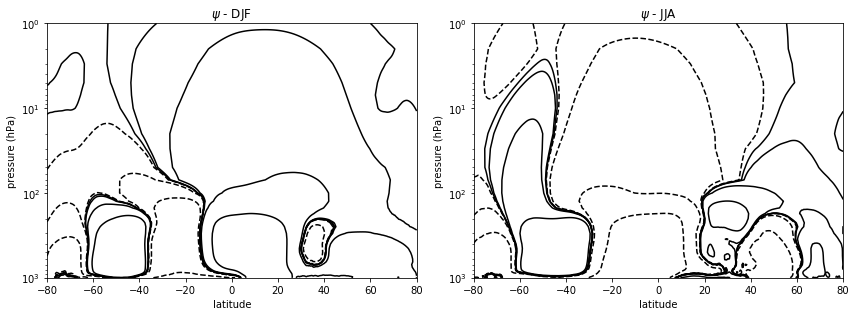

In [4]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(12, 4.5)

psi_seasonal = psi.groupby('time.season').mean('time')
seasons = ['DJF', 'JJA']
levels = np.array([-1000, -100, -10, -1, 0, 1, 10, 100, 1000])

for season, ax in zip(seasons, axes):
    data = psi_seasonal.sel(season=season)
    ax.invert_yaxis()
    
    ax.contour(
        data.latitude, data.pressure, data,
        levels=levels, colors='k'
    )
    
    ax.set_yticks(levels[-4:])
    ax.set_yscale('log')
    
    ax.set_xlabel('latitude')
    ax.set_ylabel('pressure (hPa)')
    ax.set_title(f'$\psi$ - {season}')

plt.tight_layout()

We seem to reproduce the DJF streamfunction in Seviour et al. (2012) rather well, though the structure of the JJA streamfunction seems rather different.

Let's move on to plotting the vertical component of the residual circulation $\bar{w}^\ast$. Below we reproduce Figure 2 in Seviour et al. (2012), showing the time mean $\bar{w}^\ast$ at the $70 \textrm{ hPa}$ level.

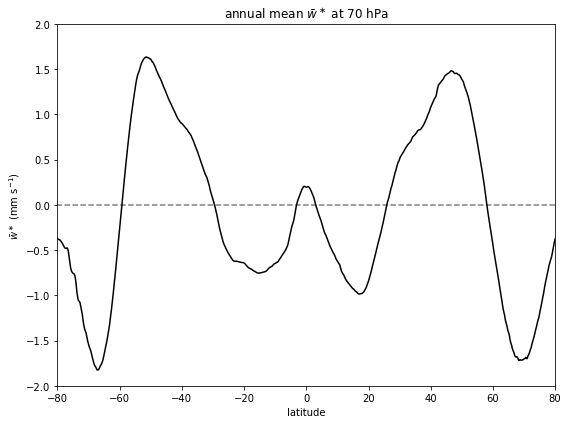

In [5]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)

w_star_70 = 1000 * w_star.sel(pressure=100, method='nearest').mean('time')
ax.plot(w_star_70.latitude, w_star_70, color='k', zorder=10)
ax.plot(w_star_70.latitude, 0 * w_star_70, color='gray', ls='dashed')

ax.set_xlim(-80, 80)
ax.set_ylim(-2, 2)

ax.set_xlabel('latitude')
ax.set_ylabel(r'$\bar{w}^\ast$ (mm s$^{-1}$)')
ax.set_title(r'annual mean $\bar{w}^\ast$ at 70 hPa')

plt.tight_layout()

To me, the above plot looks considerably different from the reference figure. There are some qualitative similarities &mdash; peaks surrounding a dip around the equator &mdash; but in the above there is a small peak centered at the equator not observed by Seviour et al. (2012), and the peaks are shifted considerably poleward.

Next, we make a version of Figure 4 from the paper, to see the annual cycle in the zero contour of $\bar{w}^\ast$.

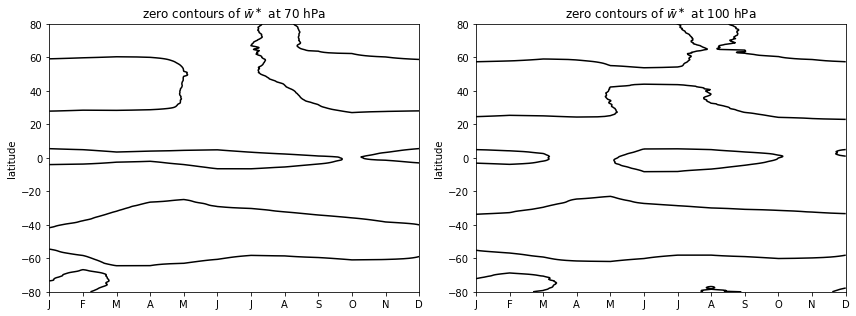

In [6]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(12, 4.5)

w_star_monthly = w_star.groupby('time.month').mean('time')
plevels = [70, 100]

for plevel, ax in zip(plevels, axes):
    data = w_star_monthly.sel(pressure=plevel, method='nearest')
    ax.contour(
        data.month, data.latitude, data.T,
        levels=[0], colors='k'
    )
    
    ax.set_xticks(np.arange(12) + 1)
    ax.set_xticklabels(list('JFMAMJJASOND'))
    
    ax.set_ylabel('latitude')
    ax.set_title(r'zero contours of $\bar{w}^\ast$ at ' + f'{plevel} hPa')
    
plt.tight_layout()

The northward shift of the tropical pipe each spring is visible at both levels, although it is much less pronounced than in the paper, and at $70 \textrm{ hPa}$ the contours do not stay along the north edge of the pipe. In addition, there seem to be more spurious zero contours here than in the paper.

Next, we'll plot the tropical mass flux, given by
$$2\pi \int_{\vartheta_-}^{\vartheta_+} \bar{w}^\ast \rho a^2\cos\vartheta \textrm{ d}\vartheta$$
where $\vartheta_-$ and $\vartheta_+$ are the southern and northern edges of the tropical pipe, respectively. Ideally, we would define these "turnaround latitudes" based on where $\bar{w}^\ast$ goes from tropical upwelling to extratropical downwelling. However, the two previous figures indicate that our $\bar{w}^\ast$ lacks the clear difference between tropics and extratropics, so it is hard to choose turnaround latitudes consistently. Instead, we use the simpler approach in Seviour et al. (2012), taking a fixed latitude band and calculating the mass flux between $25\mathrm{S}$ and $25\mathrm{N}$.

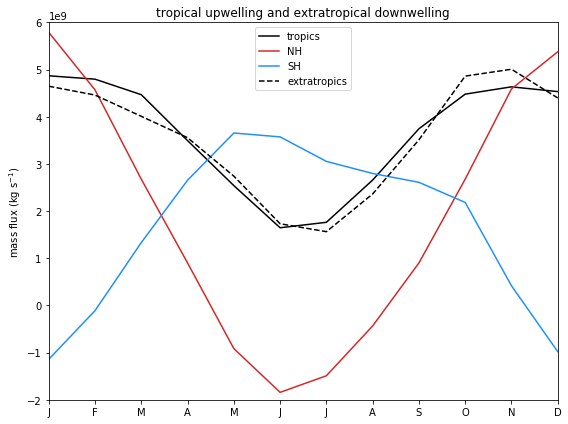

In [7]:
a = 6.37e6
level = 70
edge = 25

def calculate_mass_flux(level, domain):
    w_star_lev = w_star.sel(pressure=level, method='nearest').drop('pressure')
    integrand = 2 * np.pi * w_star_lev * (100 * level / p_surf) * (a ** 2) * np.cos(lat)
    
    lat_region = lat.sel(latitude=domain)
    integrand = integrand.sel(latitude=domain).assign_coords(latitude=lat_region)
    
    return integrand.integrate('latitude')

flux_tropics = calculate_mass_flux(level, slice(edge, -edge))
flux_nh = -calculate_mass_flux(level, slice(None, edge))
flux_sh = -calculate_mass_flux(level, slice(-edge, None))

tasks = [
    (flux_tropics, 'tropics', 'k', 'solid'),
    (flux_nh, 'NH', 'tab:red', 'solid'),
    (flux_sh, 'SH', 'dodgerblue', 'solid'),
    (flux_nh + flux_sh, 'extratropics', 'k', 'dashed')
]

fig, ax = plt.subplots()
fig.set_size_inches(8, 6)

for flux, label, color, ls in tasks:
    monthly = flux.groupby('time.month').mean('time')
    ax.plot(monthly.month, monthly, color=color, ls=ls, label=label)

ax.set_xlim(1, 12)
ax.set_ylim(-2e9, 6e9)
    
ax.set_xticks(np.arange(12) + 1)
ax.set_xticklabels(list('JFMAMJJASOND'))

ax.set_ylabel('mass flux (kg s$^{-1}$)')
ax.set_title('tropical upwelling and extratropical downwelling')

ax.legend()
plt.tight_layout()

The above figure is rather reassuring to me, as it is quite similar to that in the Seviour et al. (2012) paper. The annual upwelling is in phase with the northern hemisphere. Moreover, the combined extratropical downwelling is quite similar to the tropical upwelling. For comparison, we now calculate the annual mean tropical upwelling.

In [8]:
mass_flux_mean = flux_tropics.mean('time').item()
print(f'Annual mean tropical mass flux is {mass_flux_mean:.2e} kg/s.')

Annual mean tropical mass flux is 3.64e+09 kg/s.


This value is somewhat lower than the $5.9 \times 10^9 \textrm{ kg s}^{-1}$ found by Seviour et al. (2012), indicating that despite the qualitative similarities in the annual mass flux cycle our results our quantitatively different.

Finally, let's look at the trend. We plot the tropical upwelling at a few levels and with fixed latitude bands of several widths.

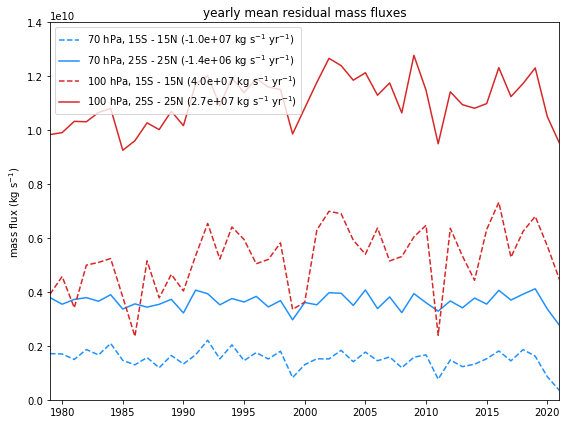

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)

levels = [70, 100]
edges = [15, 25]

for level in levels:
    for edge in edges:
        flux = calculate_mass_flux(level, slice(edge, -edge))
        flux_yearly = flux.groupby('time.year').mean('time')  
        c, _ = np.polyfit(flux_yearly.year, flux_yearly.values, deg=1)
        
        ax.plot(
            flux_yearly.year, flux_yearly, 
            color=('tab:red' if level == 100 else 'dodgerblue'),
            ls=('solid' if edge == 25 else 'dashed'), 
            label=f'{level} hPa, {edge}S - {edge}N ({c:.1e} kg s$^{{-1}}$ yr$^{{-1}}$)'
        )
        
ax.set_xlim(1979, 2021)
ax.set_ylim(0, 14e9)

ax.set_ylabel('mass flux (kg s$^{-1}$)')
ax.set_title('yearly mean residual mass fluxes')

ax.legend(loc='upper left')
plt.tight_layout()

Evidently, consistent with Seviour et al. (2012), we detect no significant (or even large) trends in any mass flux calculations using a fixed tropical latitude band of any width at any pressure level.